In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Load cleaned data
train_clean = pd.read_csv("solar_train_clean.csv")
val_clean   = pd.read_csv("solar_val_clean.csv")
test_clean  = pd.read_csv("solar_test_clean.csv")

TARGET_COL = "Leistung"
feature_cols = [c for c in train_clean.columns if c != TARGET_COL]

# 2. Scale features (fit on TRAIN only)
scaler = StandardScaler()
scaler.fit(train_clean[feature_cols])

train_scaled = train_clean.copy()
val_scaled   = val_clean.copy()
test_scaled  = test_clean.copy()

train_scaled[feature_cols] = scaler.transform(train_clean[feature_cols])
val_scaled[feature_cols]   = scaler.transform(val_clean[feature_cols])
test_scaled[feature_cols]  = scaler.transform(test_clean[feature_cols])

# 3. Window function: 24 → 1
def create_windows(df, feature_cols, target_col,
                   input_window=24, output_horizon=1):
    feats = df[feature_cols].values
    target = df[target_col].values

    n_total = len(df)
    n_features = feats.shape[1]
    n_samples = n_total - input_window - output_horizon + 1

    X = np.zeros((n_samples, input_window, n_features), dtype=np.float32)
    y = np.zeros((n_samples, output_horizon), dtype=np.float32)

    for i in range(n_samples):
        X[i] = feats[i : i + input_window]
        y[i] = target[i + input_window : i + input_window + output_horizon]

    return X, y

INPUT_WINDOW   = 24
OUTPUT_HORIZON = 1

X_train, y_train = create_windows(train_scaled, feature_cols, TARGET_COL,
                                  INPUT_WINDOW, OUTPUT_HORIZON)
X_val,   y_val   = create_windows(val_scaled,   feature_cols, TARGET_COL,
                                  INPUT_WINDOW, OUTPUT_HORIZON)
X_test,  y_test  = create_windows(test_scaled,  feature_cols, TARGET_COL,
                                  INPUT_WINDOW, OUTPUT_HORIZON)

# flatten y from (N,1) → (N,)
y_train = y_train.ravel()
y_val   = y_val.ravel()
y_test  = y_test.ravel()

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


X_train: (61344, 24, 20) y_train: (61344,)
X_val  : (8735, 24, 20) y_val  : (8735,)
X_test : (2901, 24, 20) y_test : (2901,)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

INPUT_WINDOW = X_train.shape[1]   # 24
n_features   = X_train.shape[2]   # 20

model = models.Sequential([
    layers.Input(shape=(INPUT_WINDOW, n_features)),

    layers.Conv1D(32, kernel_size=3, padding="causal", activation="relu"),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(64, kernel_size=3, padding="causal", activation="relu"),
    layers.MaxPooling1D(pool_size=2),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),

    layers.Dense(1)   # next-hour power
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 24, 32)         │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,865 (128.38 KB)

 Trainable params: 32,865 (128.38 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=["mae"]
)

es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
rlr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=128,
    callbacks=[es, rlr],
    verbose=1
)


Epoch 1/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5728 - mae: 0.4479 - val_loss: 1.6012 - val_mae: 0.7809 - learning_rate: 0.0010
Epoch 2/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3708 - mae: 0.3462 - val_loss: 1.2126 - val_mae: 0.6790 - learning_rate: 0.0010
Epoch 3/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2897 - mae: 0.3073 - val_loss: 1.1679 - val_mae: 0.6711 - learning_rate: 0.0010
Epoch 4/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2431 - mae: 0.2812 - val_loss: 0.8931 - val_mae: 0.5877 - learning_rate: 0.0010
Epoch 5/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2102 - mae: 0.2628 - val_loss: 0.8694 - val_mae: 0.5805 - learning_rate: 0.0010
Epoch 6/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1900 - mae: 0.2501 - val_loss: 0.9153 - val_mae: 0.6012 - learning_rate: 0.0010
Epoch 7/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1773 - mae: 0.2405 - val_loss: 0.8504 - val_mae: 0.5748 - learning_rate: 0.0010
Epoch 

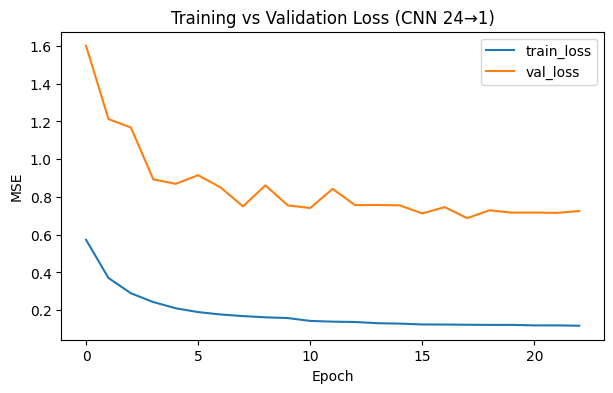

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training vs Validation Loss (CNN 24→1)")
plt.show()


In [11]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


Test MSE: 0.7859, Test MAE: 0.5305


In [12]:
def forecast_next_h(model, last_24_df, feature_cols, target_col,
                    scaler, horizon=6):
    """
    last_24_df : pandas DataFrame with exactly 24 rows, time-ordered
                 columns = [Leistung] + feature_cols
    horizon    : how many future hours to predict
    Returns: np.array of shape (horizon,)
    """

    assert len(last_24_df) == 24, "last_24_df must have 24 rows"

    history = last_24_df.copy()
    preds = []

    for step in range(horizon):
        # scale features for current 24h window
        feats_scaled = scaler.transform(history[feature_cols])
        X_win = feats_scaled.astype(np.float32)[None, ...]  # shape (1,24,20)

        # predict next hour power
        next_power = model.predict(X_win, verbose=0)[0, 0]
        preds.append(next_power)

        # build "next row" for history
        # here we keep other features same as last row (persistence)
        next_row = history.iloc[-1].copy()
        next_row[target_col] = next_power

        # append and keep only last 24 rows
        history = pd.concat([history, next_row.to_frame().T], ignore_index=True)
        history = history.iloc[-24:]

    return np.array(preds)


In [13]:
# assume you have the last 24 real rows from your time series:
last_24_df = train_clean.tail(24)  # in real app, this comes from DB / sensors

future_6 = forecast_next_h(
    model,
    last_24_df=last_24_df,
    feature_cols=feature_cols,
    target_col=TARGET_COL,
    scaler=scaler,
    horizon=6
)

print("Next 6-hour forecast:", future_6)


Next 6-hour forecast: [-0.00170473 -0.00170473 -0.00170473 -0.01324451 -0.01436507  0.00673306]
